In [37]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Read the combined dataset
combined_df = pd.read_csv("combined_data_with_id_ordered.csv")

# Check for missing values
missing_values = combined_df.isnull().sum()
print("Missing Values:\n", missing_values)

# Convert 'timestamp' column to datetime format
combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'])

# Optionally, perform feature scaling
columns_to_scale = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
scaler = StandardScaler()
combined_df[columns_to_scale] = scaler.fit_transform(combined_df[columns_to_scale])

# Display the first few rows of the modified DataFrame
print("\nModified DataFrame:")
print(combined_df.head())

# Function to detect and remove extreme outliers using the IQR method with a higher multiplier
def remove_extreme_outliers_iqr(df, columns, multiplier=3.0):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Apply the outlier removal function to the relevant columns with a higher multiplier
columns_to_check = columns_to_scale  # The same columns that were scaled
original_shape = combined_df.shape
cleaned_df = remove_extreme_outliers_iqr(combined_df, columns_to_check, multiplier=3.0)
cleaned_shape = cleaned_df.shape

# Display the first few rows of the cleaned DataFrame
print("\nCleaned DataFrame:")
print(cleaned_df.head())

# Display the number of rows before and after removing outliers
print("\nOriginal number of rows:", original_shape[0])
print("Number of rows after removing outliers:", cleaned_shape[0])



Missing Values:
 timestamp    0
back_x       0
back_y       0
back_z       0
thigh_x      0
thigh_y      0
thigh_z      0
label        0
id           0
dtype: int64

Modified DataFrame:
                timestamp    back_x    back_y    back_z   thigh_x   thigh_y  \
0 2019-01-12 00:00:00.000  0.330293  1.353248  1.749055 -7.181078 -0.822551   
1 2019-01-12 00:00:00.010  0.939690  1.276724  1.341687  2.387553  0.684944   
2 2019-01-12 00:00:00.020 -0.757338  0.863492  0.006493  0.893189 -0.255631   
3 2019-01-12 00:00:00.030  0.625506  0.129082  0.315552 -1.531676 -2.501871   
4 2019-01-12 00:00:00.040  1.403332 -0.166845  0.153423  0.075705  0.308988   

    thigh_z  label  id  
0  0.454455      6   0  
1 -0.047014      6   0  
2 -1.209252      6   0  
3 -0.809751      6   0  
4 -1.397501      6   0  

Cleaned DataFrame:
                timestamp    back_x    back_y    back_z   thigh_x   thigh_y  \
1 2019-01-12 00:00:00.010  0.939690  1.276724  1.341687  2.387553  0.684944   
2 2019-01-1

In [38]:
# Display the number of each class in the cleaned DataFrame
if 'label' in cleaned_df.columns:
    class_counts = cleaned_df['label'].value_counts()
    print("\nNumber of instances in each class after cleaning:")
    print(class_counts)
else:
    
    print("\n'label' column not found in the DataFrame.")


Number of instances in each class after cleaning:
label
7      2901130
1      1044552
6       741823
13      388586
3       250329
4        71723
2        61348
5        56013
14       48413
130      41555
8         8105
140       7808
Name: count, dtype: int64


In [39]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the selected columns
cleaned_df[columns_to_scale] = scaler.fit_transform(cleaned_df[columns_to_scale])

In [5]:
from sklearn.model_selection import train_test_split
Z = cleaned_df.drop(columns=['timestamp', 'label', 'id'])
T = cleaned_df['label']

# Ensure stratified sampling
Z_train, Z_test, T_train, T_test = train_test_split(Z, T, test_size=0.2, random_state=42, stratify=T)


### Parameters Tuning

In developing the artificial neural network (ANN), achieving optimal performance necessitated a meticulous exploration of parameters such as layer depth and neuron count. This process involved **iterative refinement through trial and error**. Essential to this endeavor was the implementation of **early stopping** techniques, vital for **preventing overfitting**. Through this iterative process, we identified configurations that not only maximized accuracy and performance metrics but also minimized error. 

Given the substantial size of our dataset, comprising over 5 million rows, we settled on a network architecture featuring four layers of neurons. Training this model required 100 epochs with a batch size of 450, a strategy aimed at accommodating the dataset's magnitude while maintaining computational efficiency.

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assume you have already loaded your dataset into X and y
X = cleaned_df.drop(columns=['timestamp', 'label', 'id'])
y = cleaned_df['label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Define a function to create the model
def create_model():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(y_categorical.shape[1], activation='softmax'))

    # Compile the model with AdamW optimizer
    optimizer = AdamW(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Create the model
model = create_model()

# Early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=450, callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
train_loss, train_accuracy = model.evaluate(X_train, y_train)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

# Generate predictions
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)

# Save the model
model.save("harth_ann_model.keras")


Epoch 1/100
7995/7995 ━━━━━━━━━━━━━━━━━━━━ 112s 14ms/step - accuracy: 0.8290 - loss: 0.5316 - val_accuracy: 0.8724 - val_loss: 0.3827
Epoch 2/100
7995/7995 ━━━━━━━━━━━━━━━━━━━━ 109s 14ms/step - accuracy: 0.8724 - loss: 0.3817 - val_accuracy: 0.8757 - val_loss: 0.3708
Epoch 3/100
7995/7995 ━━━━━━━━━━━━━━━━━━━━ 109s 14ms/step - accuracy: 0.8763 - loss: 0.3660 - val_accuracy: 0.8785 - val_loss: 0.3582
Epoch 4/100
7995/7995 ━━━━━━━━━━━━━━━━━━━━ 109s 14ms/step - accuracy: 0.8791 - loss: 0.3563 - val_accuracy: 0.8793 - val_loss: 0.3543
Epoch 5/100
7995/7995 ━━━━━━━━━━━━━━━━━━━━ 116s 14ms/step - accuracy: 0.8801 - loss: 0.3508 - val_accuracy: 0.8807 - val_loss: 0.3492
Epoch 6/100
7995/7995 ━━━━━━━━━━━━━━━━━━━━ 109s 14ms/step - accuracy: 0.8813 - loss: 0.3466 - val_accuracy: 0.8810 - val_loss: 0.3487
Epoch 7/100
7995/7995 ━━━━━━━━━━━━━━━━━━━━ 110s 14ms/step - accuracy: 0.8820 - loss: 0.3430 - val_accuracy: 0.8827 - val_loss: 0.3418
Epoch 8/100
7995/7995 ━━━━━━━━━━━━━━━━━━━━ 110s 14ms/step - ac

The high accuracy of 88.9% for training and 88.8% for testing underscores the effectiveness of early stopping in mitigating overfitting. Additionally, the marginal decrease in accuracy from training to testing suggests a well-generalized model, reflecting its robustness in unseen data.

In [41]:
# Inverse transform the encoded labels
y_test_true_classes_original = label_encoder.inverse_transform(y_test_true_classes)
y_test_pred_classes_original = label_encoder.inverse_transform(y_test_pred_classes)

# Classification report
class_report = classification_report(y_test_true_classes_original, y_test_pred_classes_original)
print("\nClassification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           1       0.77      0.88      0.82    208974
           2       0.79      0.64      0.70     12269
           3       0.48      0.25      0.33     49964
           4       0.61      0.22      0.33     14547
           5       0.52      0.10      0.17     11094
           6       0.82      0.88      0.85    148341
           7       1.00      1.00      1.00    580097
           8       0.99      0.90      0.94      1637
          13       0.82      0.89      0.85     77870
          14       0.69      0.59      0.64      9689
         130       0.60      0.52      0.56      8246
         140       0.60      0.50      0.54      1549

    accuracy                           0.89   1124277
   macro avg       0.72      0.61      0.64   1124277
weighted avg       0.88      0.89      0.88   1124277



The classification report provides insights into the model's performance across different classes. Overall, the model demonstrates **high accuracy, precision, and recall, f1-score** for several classes, but **some classes exhibit lower performance metrics**, indicating unbalance in the predictions destibution over classes. 

The overall F1 score of 88 indicates a strong performance.

In [42]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_true_classes, y_test_pred_classes)
print("\nConfusion Matrix:\n", conf_matrix)


Confusion Matrix:
 [[183630   1089   6190    978    607  10458    467      3   4507    669
     294     82]
 [  3482   7818     39     54    132     56    294      3    235    148
       8      0]
 [ 19222     88  12299    182     46  16321    321      3   1097     97
     231     57]
 [  8059    144    321   3236     64    446     71      0   1896    235
      62     13]
 [  8458    311    139    103   1123    204     27      1    620     94
      10      4]
 [  9905     44   6071     86     24 130827    338      0    712     72
     232     30]
 [   853     55    121     28      5    196 578151      6    634      5
      41      2]
 [    33     21      5      0      0      1     84   1479     14      0
       0      0]
 [  4502    200    164    423     96    257    364      3  69115    943
    1689    114]
 [  1105    145     34    142     44     90     20      0   2027   5688
     226    168]
 [   411      6     61     44      4    126     44      0   3058    168
    4273     51]
 

The noticeable imbalance is evident in the large values along the diagonal for certain classes, such as the first and seventh, compared to the smaller true predictions for classes 4 and 5.

In [43]:
# Calculate average F1 score
f1_macro = f1_score(y_test_true_classes, y_test_pred_classes, average='macro')
f1_weighted = f1_score(y_test_true_classes, y_test_pred_classes, average='weighted')
print(f"\nMacro Average F1 Score: {f1_macro}")
print(f"Weighted Average F1 Score: {f1_weighted}")

# Additional Metrics
precision = precision_score(y_test_true_classes, y_test_pred_classes, average='weighted')
recall = recall_score(y_test_true_classes, y_test_pred_classes, average='weighted')
f1 = f1_score(y_test_true_classes, y_test_pred_classes, average='weighted')

print("\nAdditional Metrics:")
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)



Macro Average F1 Score: 0.6434863327054018
Weighted Average F1 Score: 0.8774170366510468

Additional Metrics:
Precision: 0.8775937325162875
Recall: 0.8880444943728281
F1-Score: 0.8774170366510468


In [44]:
from sklearn.metrics import recall_score

# Calculate recall for each class
class_recalls = []
for class_label in set(y_test_true_classes):
    class_indices = (y_test_true_classes == class_label)
    class_recall = recall_score(y_test_true_classes, y_test_pred_classes, labels=[class_label], average='macro')
    class_recalls.append(class_recall)
    print(f'Recall for class {class_label}: {class_recall:.2f}')

# Number of levels (classes)
num_classes = len(set(y_test_true_classes))
print(f'Number of classes: {num_classes}')

# Calculate harmonic mean of class recalls
harmonic_mean_recall = num_classes / sum(1.0 / recall for recall in class_recalls)
print(f'Harmonic mean of class recalls: {harmonic_mean_recall:.2f}')


Recall for class 0: 0.88
Recall for class 1: 0.64
Recall for class 2: 0.25
Recall for class 3: 0.22
Recall for class 4: 0.10
Recall for class 5: 0.88
Recall for class 6: 1.00
Recall for class 7: 0.90
Recall for class 8: 0.89
Recall for class 9: 0.59
Recall for class 10: 0.52
Recall for class 11: 0.50
Number of classes: 12
Harmonic mean of class recalls: 0.39


Here, we observe a low average class accuracy, indicating the imbalance in the dataset.

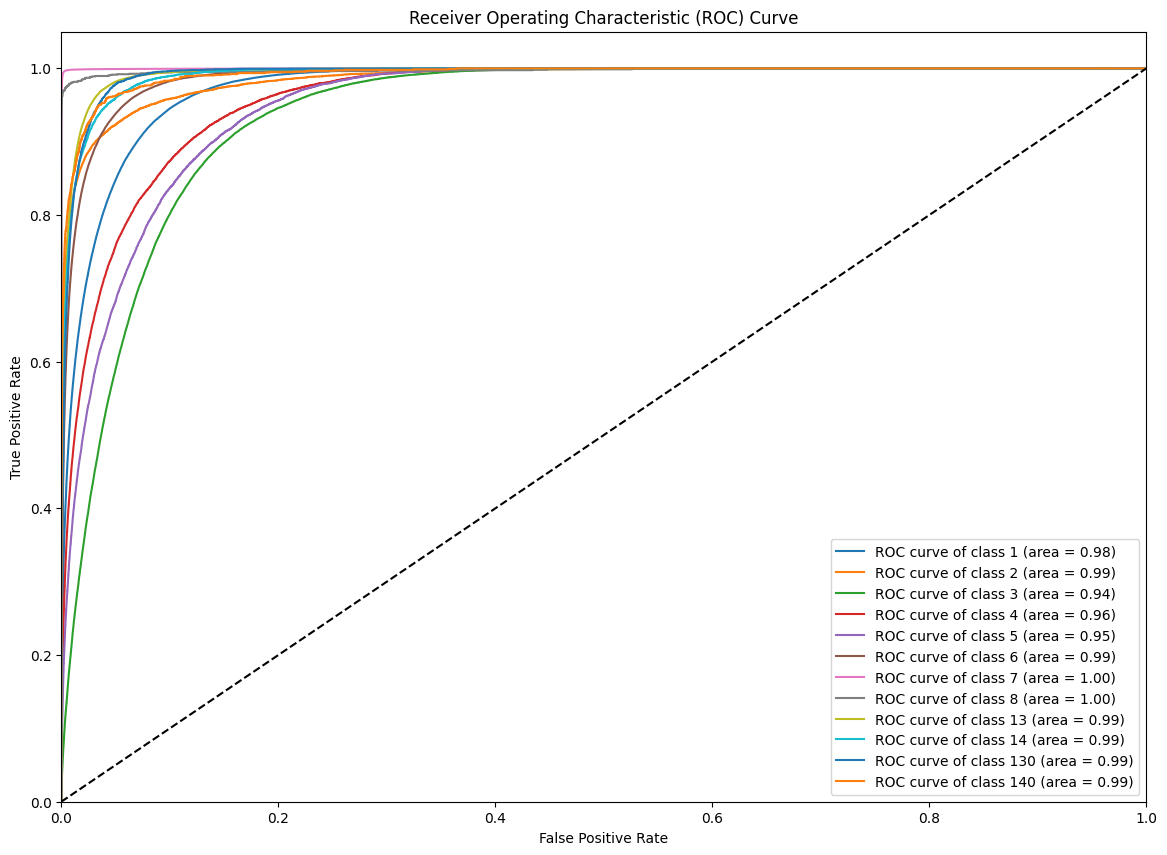

In [45]:
# Plot ROC curve for each class
y_test_binarized = label_binarize(y_test_true_classes, classes=np.arange(y_categorical.shape[1]))
n_classes = y_test_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting all ROC curves
plt.figure(figsize=(14, 10))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


The ROC curves being high for each class indicate that the model's performance is better than random guessing, reflecting its ability in distinguishing between positive and negative instances, espacialy class 7 and 1

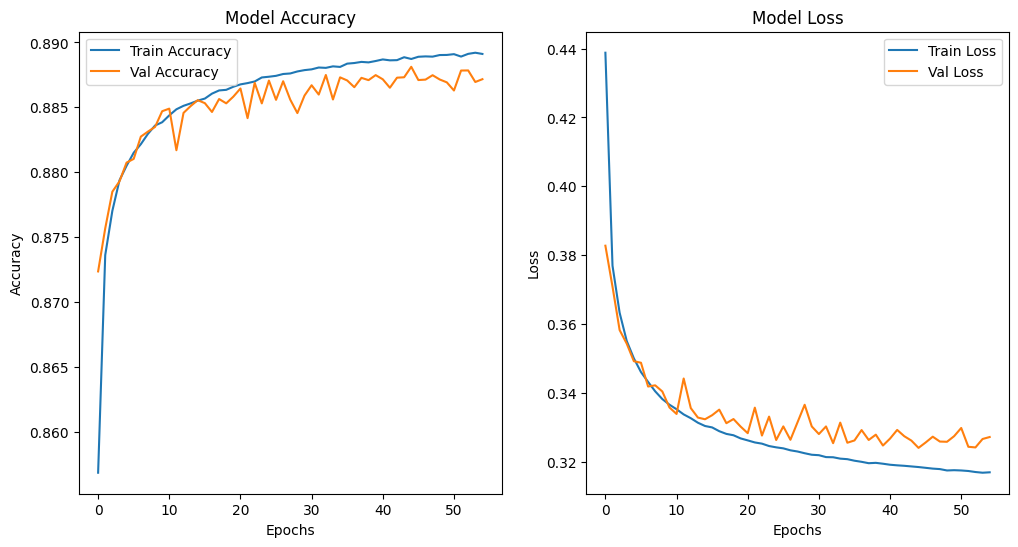

In [47]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

The validation accuracy closely mirrors the training accuracy with minimal errors, suggesting good performance.

## Trying to balance data with RandomUnderSampler

In [29]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import numpy as np

# Assume you have already loaded your dataset into X and y
X = cleaned_df.drop(columns=['timestamp', 'label', 'id'])
y = cleaned_df['label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Undersample the dataset
undersample = RandomUnderSampler(sampling_strategy='majority')
X_resampled, y_resampled = undersample.fit_resample(X, y_encoded)

# Ensure stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Convert labels to categorical
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# Define a function to create the model
def create_model():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(y_train_categorical.shape[1], activation='softmax'))

    # Compile the model with AdamW optimizer
    optimizer = AdamW(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Create the model
model = create_model()

# Early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(X_train, y_train_categorical, validation_split=0.2, epochs=100, batch_size=450, callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
train_loss, train_accuracy = model.evaluate(X_train, y_train_categorical)
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

# Generate predictions
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test_categorical, axis=1)



Epoch 1/100
3880/3880 ━━━━━━━━━━━━━━━━━━━━ 49s 12ms/step - accuracy: 0.6576 - loss: 1.0338 - val_accuracy: 0.7394 - val_loss: 0.7742
Epoch 2/100
3880/3880 ━━━━━━━━━━━━━━━━━━━━ 51s 13ms/step - accuracy: 0.7441 - loss: 0.7543 - val_accuracy: 0.7529 - val_loss: 0.7226
Epoch 3/100
3880/3880 ━━━━━━━━━━━━━━━━━━━━ 52s 13ms/step - accuracy: 0.7519 - loss: 0.7245 - val_accuracy: 0.7576 - val_loss: 0.7012
Epoch 4/100
3880/3880 ━━━━━━━━━━━━━━━━━━━━ 50s 13ms/step - accuracy: 0.7570 - loss: 0.7046 - val_accuracy: 0.7615 - val_loss: 0.6898
Epoch 5/100
3880/3880 ━━━━━━━━━━━━━━━━━━━━ 52s 13ms/step - accuracy: 0.7597 - loss: 0.6937 - val_accuracy: 0.7639 - val_loss: 0.6805
Epoch 6/100
3880/3880 ━━━━━━━━━━━━━━━━━━━━ 49s 13ms/step - accuracy: 0.7626 - loss: 0.6830 - val_accuracy: 0.7612 - val_loss: 0.6869
Epoch 7/100
3880/3880 ━━━━━━━━━━━━━━━━━━━━ 50s 13ms/step - accuracy: 0.7645 - loss: 0.6772 - val_accuracy: 0.7665 - val_loss: 0.6725
Epoch 8/100
3880/3880 ━━━━━━━━━━━━━━━━━━━━ 50s 13ms/step - accuracy: 

the accuracy had dropped so much here

In [30]:
# Inverse transform the encoded labels
y_test_true_classes_original = label_encoder.inverse_transform(y_test_true_classes)
y_test_pred_classes_original = label_encoder.inverse_transform(y_test_pred_classes)

# Classification report
class_report = classification_report(y_test_true_classes_original, y_test_pred_classes_original)
print("\nClassification Report:\n", class_report)

# Save the model
model.save("harth_ann_model.keras")


Classification Report:
               precision    recall  f1-score   support

           1       0.78      0.88      0.82    208910
           2       0.80      0.66      0.72     12270
           3       0.51      0.24      0.32     50066
           4       0.56      0.29      0.38     14345
           5       0.49      0.12      0.19     11203
           6       0.81      0.90      0.85    148365
           7       0.92      0.92      0.92      1561
           8       0.96      0.94      0.95      1621
          13       0.83      0.88      0.86     77717
          14       0.69      0.59      0.64      9683
         130       0.64      0.53      0.58      8311
         140       0.67      0.49      0.57      1561

    accuracy                           0.78    545613
   macro avg       0.72      0.62      0.65    545613
weighted avg       0.76      0.78      0.76    545613



Notably, we observe improvements in precision, recall, and f1-score metrics, indicating enhanced performance across various classes. However, the dataset's imbalance is still evident, as reflected in the lower average class accuracy.

In [31]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_true_classes, y_test_pred_classes)
print("\nConfusion Matrix:\n", conf_matrix)


Confusion Matrix:
 [[183158   1095   5821   1590    880  11297     43     19   4130    599
     236     42]
 [  3263   8112     52    107    167     97     20     20    283    148
       1      0]
 [ 18307    113  11927    339     89  17977     39      5   1033     81
     140     16]
 [  7139    113    304   4155     75    468      5      1   1788    227
      64      6]
 [  8194    319    153    203   1318    228      0      2    653    116
      15      2]
 [  9489     42   4723    189     28 133122      8      0    547     71
     132     14]
 [    17     11     25      0      0     25   1440      1     40      0
       2      0]
 [    49     12      4      3      0      3     10   1523     15      2
       0      0]
 [  4699    208    214    605     75    340      1      8  68733    948
    1772    114]
 [  1173    106     44    115     40     95      0      3   2167   5701
     100    139]
 [   398     15     49     66      7    218      0      0   2927    189
    4399     43]
 

In [32]:
# Calculate average F1 score
f1_macro = f1_score(y_test_true_classes, y_test_pred_classes, average='macro')
f1_weighted = f1_score(y_test_true_classes, y_test_pred_classes, average='weighted')
print(f"\nMacro Average F1 Score: {f1_macro}")
print(f"Weighted Average F1 Score: {f1_weighted}")


Macro Average F1 Score: 0.6505226332333798
Weighted Average F1 Score: 0.7563617096561394


In [33]:
# Additional Metrics
precision = precision_score(y_test_true_classes, y_test_pred_classes, average='weighted')
recall = recall_score(y_test_true_classes, y_test_pred_classes, average='weighted')
f1 = f1_score(y_test_true_classes, y_test_pred_classes, average='weighted')

print("\nAdditional Metrics:")
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Additional Metrics:
Precision: 0.7555261699769821
Recall: 0.7777527294987473
F1-Score: 0.7563617096561394


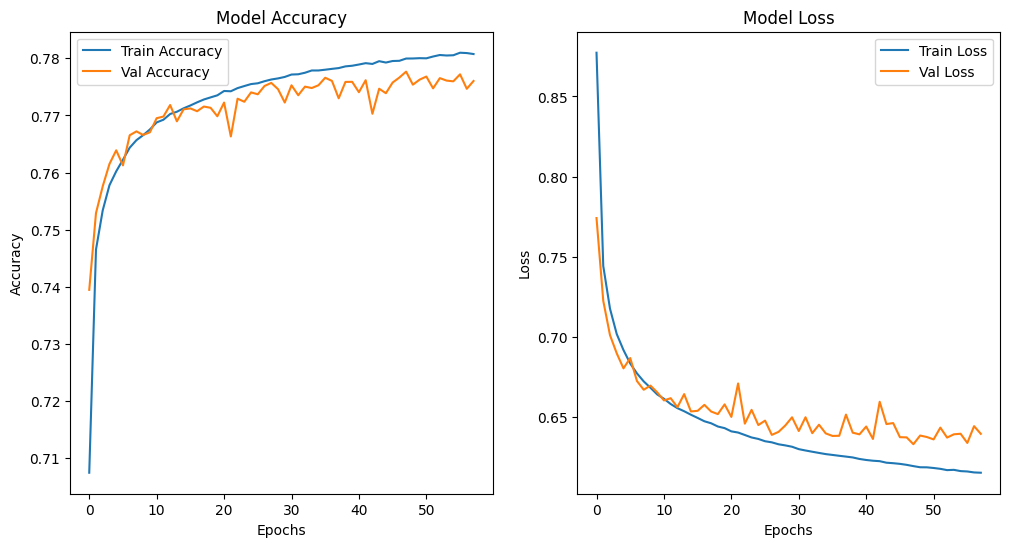

In [34]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

The validation accuracy closely mirrors the training accuracy with minimal errors, suggesting great performance.

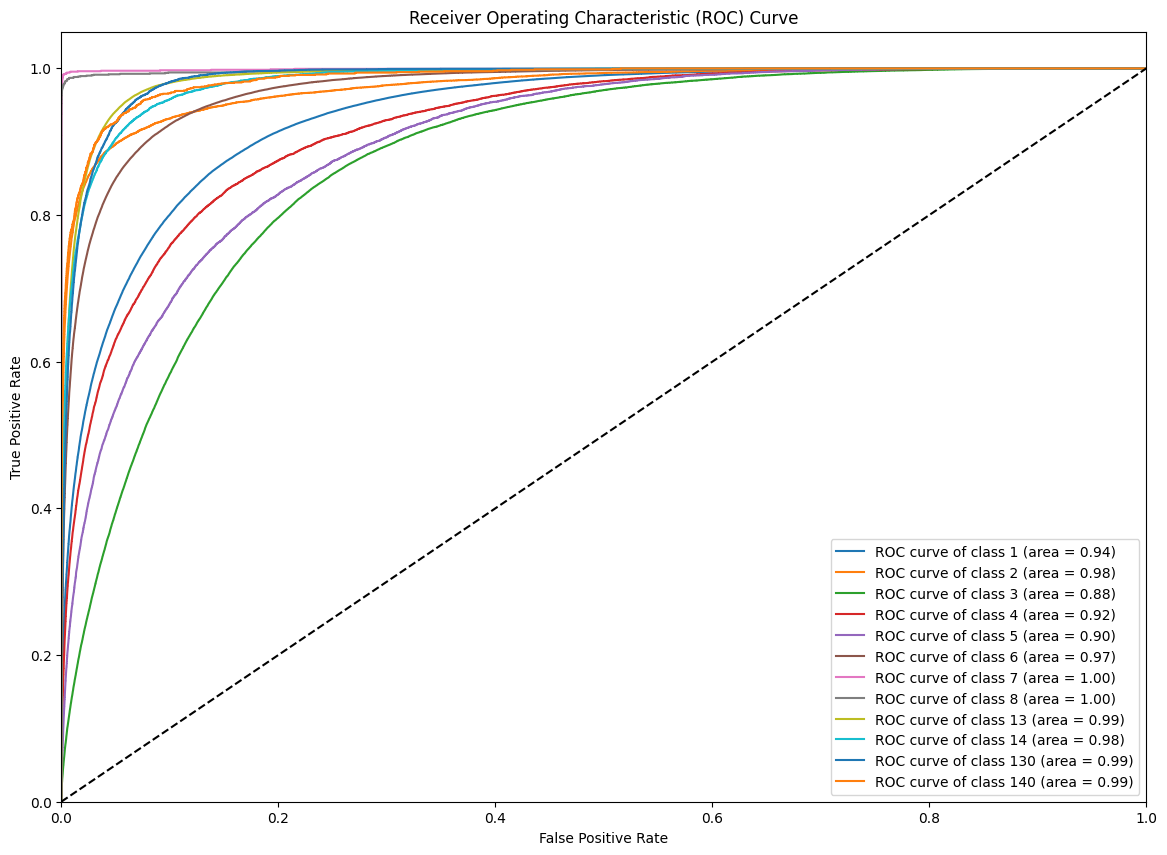

In [35]:
# Plot ROC curve for each class
y_test_binarized = label_binarize(y_test_true_classes, classes=np.arange(y_train_categorical.shape[1]))
n_classes = y_test_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plotting all ROC curves
plt.figure(figsize=(14, 10))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


The ROC curves being high for each class indicate that the model's performance is better than random guessing, reflecting its ability in distinguishing between positive and negative instances, espacialy class 7 and 1

## CONCLUSION

The Artificial Neural Network (ANN) demonstrated robust performance on a large dataset, achieving high accuracy in both training and testing phases. Employing early stopping techniques helped prevent overfitting, ensuring the model's generalization ability. However, the model exhibited imbalanced predictions, favoring certain classes over others, despite achieving high average F1 scores. Attempts to address this imbalance through techniques like Random Undersampling led to a reduction in overall accuracy, indicating a trade-off between overall accuracy and class balance. Despite these challenges, the ANN showcased promising potential for handling complex datasets, albeit with the need for further optimization to tackle class imbalance effectively.